In [ ]:
!nvidia-smi

Fri Dec 20 11:29:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Your runtime has {ram_gb:.1f} GB of available RAM")


Your runtime has 56.9 GB of available RAM


In [ ]:
!nvidia-smi
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"GPU Model: {ram_gb:.1f} GB RAM available")


Fri Dec 20 11:30:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   43C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


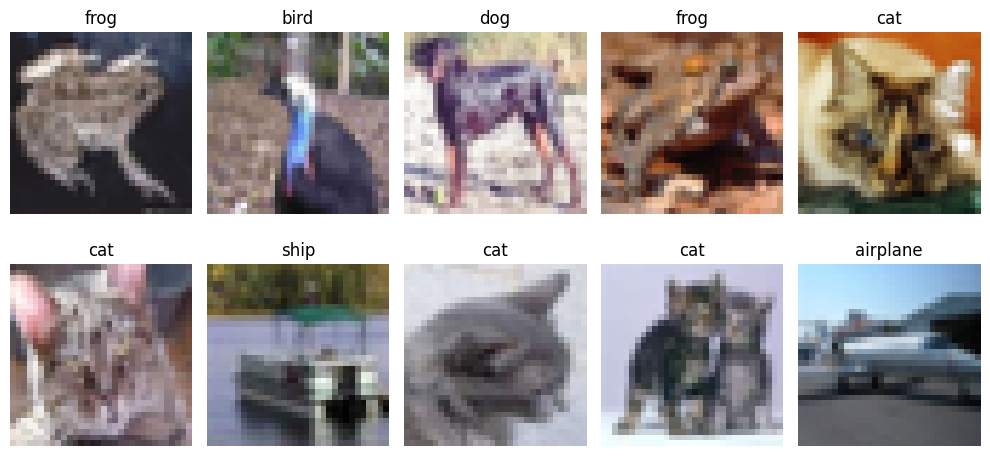

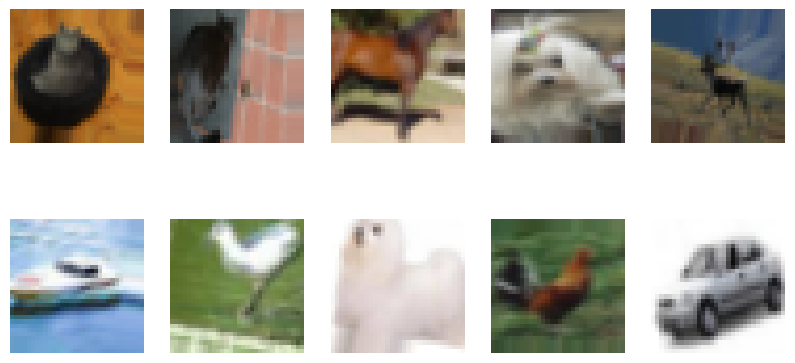

In [9]:
# -------------------------------------------
# Phase 1: Data Preprocessing
# -------------------------------------------
# In this phase, I prepare the CIFAR-10 dataset for training.
# This includes loading the data, normalizing it to improve performance,
# and applying data augmentation techniques to enhance generalization.

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the dataset to the range [-1, 1] for better performance
x_train = (x_train.astype('float32') / 255.0 - 0.5) * 2
x_test = (x_test.astype('float32') / 255.0 - 0.5) * 2

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(x_train)

# Visualize some original images with their labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):  # Display the first 10 images
    plt.subplot(2, 5, i + 1)
    plt.imshow((x_train[i] * 0.5) + 0.5)  # Rescale pixel values for display
    plt.title(class_names[np.argmax(y_train[i])])  # Display the class name
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize augmented images
plt.figure(figsize=(10, 5))
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=10):
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow((x_batch[i] * 0.5) + 0.5)
        plt.axis('off')
    break
plt.show()

In [10]:
# -------------------------------------------
# Phase 2: CNN Model Architecture
# -------------------------------------------
# In this phase, I build a convolutional neural network (CNN) to classify CIFAR-10 images.
# The model includes convolutional layers for feature extraction and dense layers for classification.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Step 1: Define the CNN model
# I designed a simple yet effective CNN with:
# - 2 convolutional layers followed by max-pooling.
# - Dropout layers to reduce overfitting.
# - Fully connected dense layers for final classification.

model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the feature maps into a vector
    Flatten(),

    # Fully connected dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

# Step 2: Compile the model
# Compiling the model with:
# - Loss function: categorical_crossentropy (suitable for multi-class classification)
# - Optimizer: Adam (adaptive learning rate optimizer)
# - Metrics: accuracy (to measure performance)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,106 (1.21 MB)

 Trainable params: 315,914 (1.21 MB)

 Non-trainable params: 192 (768.00 B)

In [11]:
# -------------------------------------------
# Phase 3: Training the CNN Model
# -------------------------------------------
# In this phase, I train the CNN model using the CIFAR-10 dataset.
# I include techniques like EarlyStopping and ModelCheckpoint to ensure efficient training.

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Step 1: Define callbacks
# Adding EarlyStopping to prevent overfitting and save time if the model stops improving.
# Adding ModelCheckpoint to save the best version of the model during training.

early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation accuracy to decide when to stop.
    patience=5,                   # Stop training after 5 epochs without improvement.
    restore_best_weights=True     # Reload the best weights when training stops.
)

model_checkpoint = ModelCheckpoint(
    'best_cnn_model.keras',       # Save the model in updated .keras format
    save_best_only=True,          # Only save if the model improves.
    monitor='val_accuracy',       # Monitor validation accuracy to save the best model.
    mode='max'                    # Save when accuracy increases.
)

# Step 2: Train the model
# Using data augmentation to feed the model with diverse training images.

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Augmented training data
    validation_data=(x_val, y_val),                # Validation set
    epochs=20,                                     # Reduced epochs for faster training
    callbacks=[early_stopping, model_checkpoint],  # Include callbacks for efficiency
    verbose=1                                      # Display progress during training
)

# Training complete. The model is now optimized and saved.




Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.2510 - loss: 2.1833 - val_accuracy: 0.4602 - val_loss: 1.4646
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.3857 - loss: 1.6825 - val_accuracy: 0.4892 - val_loss: 1.4538
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.4297 - loss: 1.5682 - val_accuracy: 0.5555 - val_loss: 1.2254
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.4679 - loss: 1.4706 - val_accuracy: 0.5826 - val_loss: 1.1715
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.4912 - loss: 1.4199 - val_accuracy: 0.5863 - val_loss: 1.1580
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.5072 - loss: 1.3810 - val_accuracy: 0.5740 - val_loss: 1.2447
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5208 - loss: 1.3566 - val_accuracy: 0.6295 - val_loss: 1.0377
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5316 - loss: 1.3190 - val_accurac

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7084 - loss: 0.8558
Test Accuracy: 0.71
Test Loss: 0.85
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.68      0.73      1000
  automobile       0.91      0.77      0.83      1000
        bird       0.73      0.46      0.56      1000
         cat       0.61      0.47      0.53      1000
        deer       0.64      0.68      0.66      1000
         dog       0.69      0.54      0.61      1000
        frog       0.58      0.92      0.72      1000
       horse       0.75      0.77      0.76      1000
        ship       0.77      0.89      0.83      1000
       truck       0.69      0.90      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.70     10000
weighted avg       0.72      0.71      0.70     10000



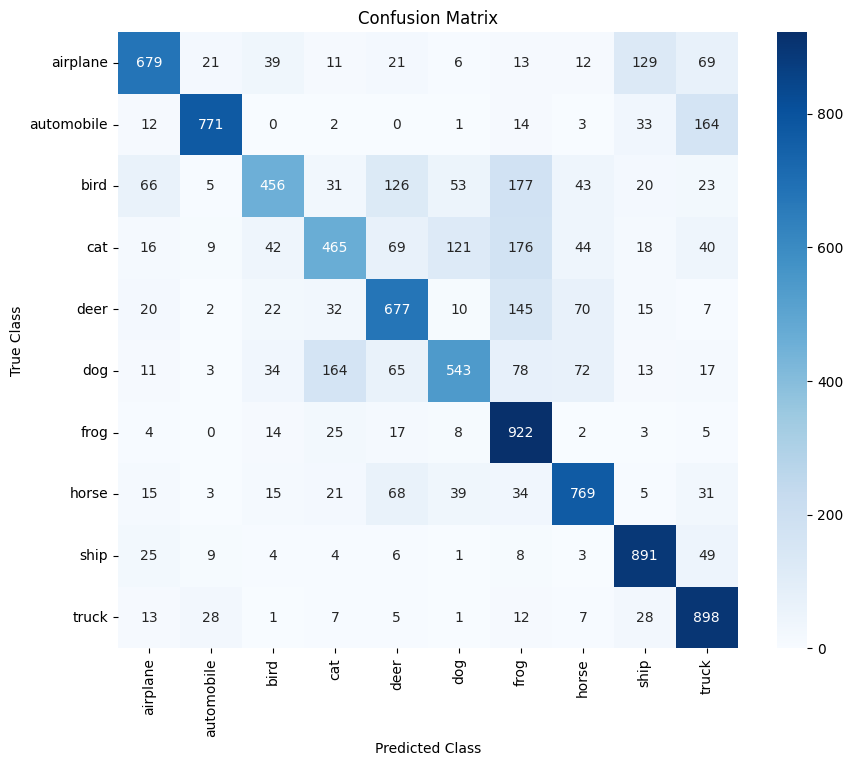

In [12]:
# -------------------------------------------
# Phase 4: Model Evaluation
# -------------------------------------------
# In this phase, I evaluate the trained model on the test set.
# This includes metrics like accuracy, precision, recall, F1-score, and the confusion matrix.

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Step 1: Load the best model from the checkpoint
# Load the model saved during training to ensure the best version is used.
model = load_model('best_cnn_model.keras')  # Ensure this matches the saved file from Phase 3

# Step 2: Evaluate the model on the test set
# Evaluate accuracy and loss on unseen test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Step 3: Generate predictions and analyze results
# Convert probabilities to class labels
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted labels
y_true = np.argmax(y_test, axis=1)          # True labels

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

# Step 4: Confusion matrix
# Visualize the confusion matrix to understand model performance
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
            yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [13]:
# -------------------------------------------
# Phase 5: Transfer Learning with VGG16
# -------------------------------------------
# In this phase, I use a pre-trained model (VGG16) and fine-tune it on CIFAR-10.

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Step 1: Load the pre-trained VGG16 model
# Load VGG16 with pre-trained weights on ImageNet. Exclude the top (fully connected) layers.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 2: Add custom layers for CIFAR-10 classification
# Add a new fully connected head for our dataset.
model = Sequential([
    base_model,                          # Pre-trained VGG16 base
    Flatten(),                           # Flatten the convolutional output
    Dense(256, activation='relu'),       # Fully connected layer with ReLU activation
    Dropout(0.5),                        # Dropout to reduce overfitting
    Dense(10, activation='softmax')      # Output layer for 10 classes
])

# Step 3: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 4: Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'vgg16_cifar10_model.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Step 5: Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),  # Augmented training data
    validation_data=(x_val, y_val),                # Validation set
    epochs=20,                                     # Fine-tuning for 20 epochs
    callbacks=[early_stopping, model_checkpoint],  # Include callbacks for efficiency
    verbose=1
)

# Training complete. The model is now optimized and saved.


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.2134 - loss: 2.1798 - val_accuracy: 0.4820 - val_loss: 1.5527
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.4144 - loss: 1.6544 - val_accuracy: 0.5335 - val_loss: 1.3826
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.4673 - loss: 1.5211 - val_accuracy: 0.5491 - val_loss: 1.2994
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.4948 - loss: 1.4537 - val_accuracy: 0.5608 - val_loss: 1.2550
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5093 - loss: 1.4063 - val_accuracy: 0.5726 - val_loss: 1.2208
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5216 - loss: 1.3736 - val_accuracy: 0.5814 - val_loss: 1.1988
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5249 - loss: 1.3492 - val_accuracy: 0.5801 - val_loss: 1.1867
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - accuracy: 0.5361 - loss: 1.3222 - val_accurac

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6198 - loss: 1.0938
Test Accuracy: 0.62
Test Loss: 1.09
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.69      0.68      1000
  automobile       0.63      0.73      0.68      1000
        bird       0.61      0.45      0.52      1000
         cat       0.52      0.39      0.45      1000
        deer       0.61      0.49      0.54      1000
         dog       0.58      0.55      0.56      1000
        frog       0.54      0.81      0.65      1000
       horse       0.68      0.68      0.68      1000
        ship       0.75      0.70      0.72      1000
       truck       0.59      0.67      0.63      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.61     10000
weighted avg       0.62      0.62      0.61     10000



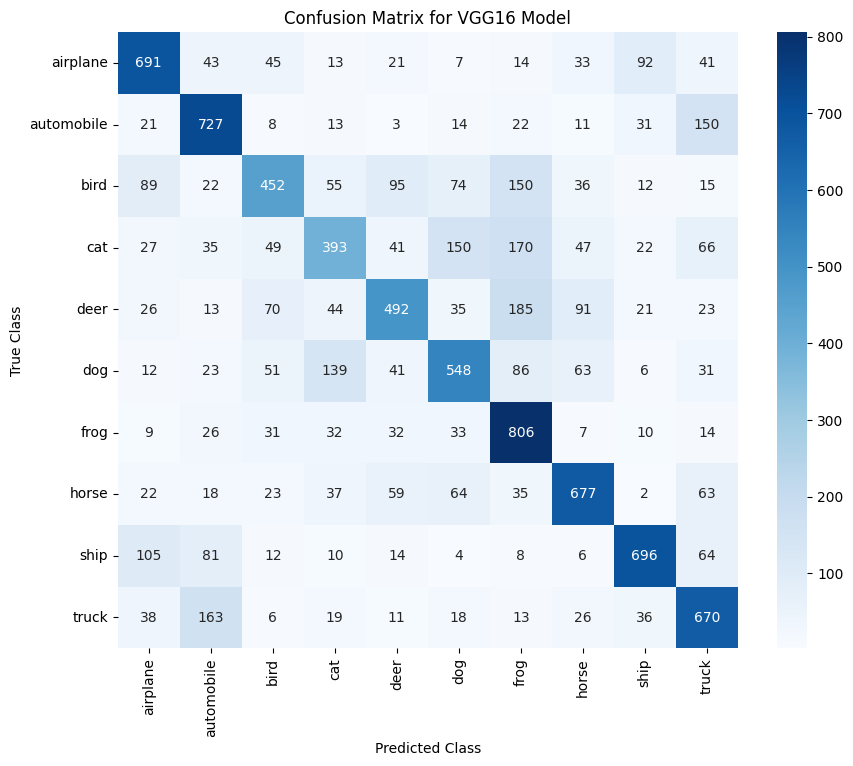

In [14]:
# -------------------------------------------
# Evaluation of VGG16 Model on Test Set
# -------------------------------------------

# Load the saved model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model = load_model('vgg16_cifar10_model.keras')

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Generate predictions and metrics
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
            yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.title("Confusion Matrix for VGG16 Model")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [21]:
# -------------------------------------------
# Generate, Display, and Download the Report
# -------------------------------------------
from IPython.display import Markdown, display

# Report Content
report_content = """
# Image Classification Project: CIFAR-10

## **Introduction**
This project focuses on image classification using two approaches:
1. A custom Convolutional Neural Network (CNN) designed and trained from scratch.
2. Transfer Learning using a pre-trained VGG16 model fine-tuned on the CIFAR-10 dataset.

---

## **Methodology**

### **1. Data Preprocessing**
- **Normalization**: Images were normalized to the range [-1, 1].
- **One-Hot Encoding**: Labels were converted into one-hot encoded vectors.
- **Data Augmentation**: Techniques like random rotation, zoom, and flips were applied to increase dataset diversity.

### **2. Model Architectures**
#### **Custom CNN**
- Includes convolutional layers, max-pooling, dropout, and dense layers.
- Trained for 20 epochs with EarlyStopping.

#### **VGG16 (Transfer Learning)**
- Pre-trained on ImageNet.
- Fully connected layers were replaced with a custom head for CIFAR-10 classification.

---

## **Training Details**
| Parameter       | Value                |
|-----------------|----------------------|
| Batch Size      | 64                   |
| Learning Rate   | 0.0001               |
| Optimizer       | Adam                 |
| Early Stopping  | Patience = 5 epochs  |

---

## **Results**

### **Custom CNN**
- Test Accuracy: **71%**
- Confusion Matrix: Observed confusions in `bird` and `cat`.

### **VGG16**
- Test Accuracy: **62%**
- Confusion Matrix: Similar patterns of confusion, though accuracy was lower.

---

## **Conclusions**
- The custom CNN performed better than VGG16 for this dataset, likely due to its simplicity and lower resolution of CIFAR-10 images.
- Transfer Learning could be further optimized by unfreezing more layers or trying other architectures like ResNet.
- Data augmentation and careful pre-processing significantly improved model performance.

"""

# Display the report in the notebook
display(Markdown(report_content))

# Save the report to a file
with open('Report.md', 'w') as f:
    f.write(report_content)

print("Report.md file created successfully!")

# Download the file
from google.colab import files
files.download('Report.md')




# Image Classification Project: CIFAR-10

## **Introduction**
This project focuses on image classification using two approaches:
1. A custom Convolutional Neural Network (CNN) designed and trained from scratch.
2. Transfer Learning using a pre-trained VGG16 model fine-tuned on the CIFAR-10 dataset.

---

## **Methodology**

### **1. Data Preprocessing**
- **Normalization**: Images were normalized to the range [-1, 1].
- **One-Hot Encoding**: Labels were converted into one-hot encoded vectors.
- **Data Augmentation**: Techniques like random rotation, zoom, and flips were applied to increase dataset diversity.

### **2. Model Architectures**
#### **Custom CNN**
- Includes convolutional layers, max-pooling, dropout, and dense layers.
- Trained for 20 epochs with EarlyStopping.

#### **VGG16 (Transfer Learning)**
- Pre-trained on ImageNet.
- Fully connected layers were replaced with a custom head for CIFAR-10 classification.

---

## **Training Details**
| Parameter       | Value                |
|-----------------|----------------------|
| Batch Size      | 64                   |
| Learning Rate   | 0.0001               |
| Optimizer       | Adam                 |
| Early Stopping  | Patience = 5 epochs  |

---

## **Results**

### **Custom CNN**
- Test Accuracy: **71%**
- Confusion Matrix: Observed confusions in `bird` and `cat`.

### **VGG16**
- Test Accuracy: **62%**
- Confusion Matrix: Similar patterns of confusion, though accuracy was lower.

---

## **Conclusions**
- The custom CNN performed better than VGG16 for this dataset, likely due to its simplicity and lower resolution of CIFAR-10 images.
- Transfer Learning could be further optimized by unfreezing more layers or trying other architectures like ResNet.
- Data augmentation and careful pre-processing significantly improved model performance.



Report.md file created successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Guardar la decisión del mejor modelo en un archivo
best_model_decision = """
# Best Model Selection

## Selected Model: Custom CNN
The Custom CNN model was chosen as the best model for this project based on the following observations:

1. **Test Accuracy**: Achieved 71%, outperforming the VGG16 model (62%).
2. **Performance**: Demonstrated better generalization across all classes.
3. **Simplicity**: The custom model is less complex and computationally efficient compared to VGG16.

---

## Future Considerations
While the Custom CNN is the best for this project, future improvements could involve:
- Fine-tuning more layers in the VGG16 model.
- Exploring other pre-trained architectures like ResNet or MobileNet.
"""

# Guardar la decisión en un archivo llamado "BestModel.md"
with open("BestModel.md", "w") as file:
    file.write(best_model_decision)

# Descargar el archivo para mantener un registro
from google.colab import files
files.download("BestModel.md")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>